#### Updated version of simple_sim

Features
- input road with starting number of cars $n_0$
- sink points (ralphs), each car $\in [n_0]$ is pursuing one of these points
- intersection probabilities are calculated as follows: for all of the routes from input to sink point for a given car, the car is equally likely to take any of them. Sum up the total routes across the network, and normalize accordingly to get the probabilities. 
- directed, acyclic graph (cars are assumed to flow from input to sink only)
- roads have max-capacities. 
For a given time *episode*,
- (traffic lights) each road will be updated ("green light") one by one, randomly. At any given "green light", $n_0$ (the current amount of cars on the round) times $cv$ (some constant times current road speed) will be the maximum number sent into the intersection, and split up according to p's. If the roads are at max capacity, this may be lower.
- The episode ends when all intersections have been updated once.

We evaluate a road network by the number of episodes needed for all initial cars to reach the sink points. This can be influenced by certain input parameters, the most important of which is **the structure of the road network**. We additionally will run experiments with constraints, including
- limiting the number of possible roads
- limiting the carrying capacity of each road
and varying other parameters, such as:
- number of initial cars
- sink point destinations for each car

In [442]:
import networkx as nx
import numpy as np
import random

def weighting(data):
    return data / data.sum()

def inv_weighting(data):
    return (1/data) / (1/data).sum()

def add_dicts(dict1, dict2):
    result = dict1.copy()
    for key, value in dict2.items():
        result[key] = result.get(key, 0) + value
    return result

class Map:
    
    # Initialization methods
    
    def __init__(self, capacity_per_length_per_lane = 0.1, green_lights_per_time = 3, ideal_send_per_lane_per_green = 10):
        self.G = nx.DiGraph()
        self.node_positions = {}
        self.capacityPLPL = capacity_per_length_per_lane
        self.idealSPLPG = ideal_send_per_lane_per_green
        self.GLPT = green_lights_per_time
        print("""
        Road network initialized. Methods: \n
        - .add_inter(label, pos)
        - .add_road(start, end, dt, speed_limit, lanes, num_cars = 0)
        - .simulation_status_check()
        """)
        
        self.num_lanes = 0
        self.total_length_of_road = 0
        self.inputs = []
        self.input_temp_nodes = []
        self.cars_to_sinks_dict = {}
        
        
    def add_inter(self, label, pos):
        # label can be int or str
        self.G.add_node(label)
        self.node_positions[label] = pos
        print(f"Intersection {label} added.")
        
    def add_road(self, start, end, dt, speed_limit, length, lanes, num_cars = 0):
        try:
            self.G.add_edge(start, end, dt=dt, capacity=self.capacityPLPL*length*lanes, speed_limit=speed_limit, length=length, lanes=lanes, num_cars=num_cars)
            print(f"Road with {lanes} lanes between {start} and {end} added.")
            self.num_lanes += lanes
            self.total_length_of_road += lanes*length
        except:
            print("Nodes do not exist.")
            
    def get_sinks(self):
        out_degrees = dict(self.G.out_degree(self.G.nodes))
        sinks = [node for node in out_degrees if out_degrees[node] == 0]
        print(sinks)
            
    # Traffic initialization
    
    def declare_inflow_node(self, source_node, initial_cars_to_sinks):
        
        mod_initial_cars_to_sinks = {(source_node, sink): initial_cars_to_sinks[sink] for sink in initial_cars_to_sinks}
        self.cars_to_sinks_dict = add_dicts(self.cars_to_sinks_dict, mod_initial_cars_to_sinks)
        initial_cars = 0
        for key in initial_cars_to_sinks:
            initial_cars += initial_cars_to_sinks[key]
        
        self.inputs.append(source_node)
        input_name = "_i" + str(len(self.inputs))
        self.G.add_node(input_name)
        self.input_temp_nodes.append(input_name)
        self.node_positions[input_name] = (self.node_positions[source_node][0] - 0.1, self.node_positions[source_node][1])
        self.add_road(input_name, source_node, dt=1, speed_limit=50, length=100, lanes=1, num_cars=initial_cars)
        self.num_lanes -= 1
        self.total_length_of_road -= 100
        
        print("Inflow node declared.")
    
    # Check and Compilation for simulation
    
    def simulation_check_compile(self):
        # Check for acyclic
        assert nx.is_directed_acyclic_graph(self.G), "Constructed road network is not acyclic. Please try again."
        
        # Store sink points, give terminations attributes
        out_degrees = dict(self.G.out_degree(self.G.nodes))
        self.sinks = [node for node in out_degrees if out_degrees[node] == 0]
        for node in self.sinks:
            self.G.nodes[node]['terminations'] = 0
        
        # Calculate and endow intersection turn probabilities
        edge_counts = {}
            # Update total cars travelled for each edge
        for source_node, sink in self.cars_to_sinks_dict.keys():
            paths = list(nx.all_simple_edge_paths(self.G, source_node, sink))
            
            # Calculate path weights from source to sink
            path_lengths = np.zeros(len(paths))
            for index, path in enumerate(paths):
                total_length = 0
                for edge in path:
                    total_length += self.G[edge[0]][edge[1]]['length']
                path_lengths[index] = total_length
            path_weights = inv_weighting(path_lengths)
            
            # Calculate num of cars on path
            route_num_cars = self.cars_to_sinks_dict[(source_node, sink)]
            path_num_cars = path_weights * route_num_cars
            
            # Add total cars travelled for each edge
            for index, path in enumerate(paths):
                for edge in path:
                    try:
                        edge_counts[edge] += path_num_cars[index]
                    except KeyError:
                        edge_counts[edge] = path_num_cars[index]
            
            # Endow intersections with probabilities
        for node in self.G.nodes:
            if node in self.input_temp_nodes:
                continue
            out_edges = list(self.G.out_edges(node))
            out_edges_cars = []
            for edge in out_edges:
                out_edges_cars.append(edge_counts[edge])
            out_edges_cars = np.array(out_edges_cars)
            out_edges_weights = weighting(out_edges_cars)
            for i, edge in enumerate(out_edges):
                self.G.nodes[node][edge] = out_edges_weights[i]
            
        
        print(f"""
        Road network satisfactory and ready for simulation. Summary:
        - Input Nodes: {self.inputs}
        - Sinks: {self.sinks}
        - Number of lanes used: {self.num_lanes}
        - Total length of road used: {self.total_length_of_road}
        - Intersection turn probabilities calculated using shortest-path simple weighting. 
          Access or manually edit through map.G.nodes attributes.
        Network sketch:
        """)
        nx.draw(self.G, self.node_positions)
        
    # Simulation, time-step update for road network
    
    def update_time(self):
        # loop through each edge non-simultaneously for each time step ("green light-red light")
        green_lights = [random.randint(0, len(self.G.edges)-1) for _ in range(self.GLPT)]
        for green_light in green_lights:
            edge = list(self.G.edges)[green_light]

            inter = edge[1]
            out_edges = list(self.G.out_edges(inter))

            # handle case leading to sink
            if len(out_edges) == 0:
                speed_factor = max(self.G[edge[0]][edge[1]]['capacity'] - self.G[edge[0]][edge[1]]['num_cars'],0) / self.G[edge[0]][edge[1]]['capacity'] + 0.2
                #print(speed_factor)
                # send calculated amount, or remaining cars in road
                to_send_num = min(self.idealSPLPG * self.G[edge[0]][edge[1]]['lanes'] * speed_factor, self.G[edge[0]][edge[1]]['num_cars'])
                if to_send_num == 0:
                    pass
                self.G.nodes[inter]['terminations'] += to_send_num
                self.G[edge[0]][edge[1]]['num_cars'] -= to_send_num
                pass

            to_send = {out_edge: self.G.nodes[inter][out_edge] for out_edge in out_edges}
            # between r>0 and 1, note that r attains smaller positive value iff road capacity is large (i.e. a huge jammed multi-lane highway vs. local road)
            speed_factor = max(self.G[edge[0]][edge[1]]['capacity'] - self.G[edge[0]][edge[1]]['num_cars'],0) / self.G[edge[0]][edge[1]]['capacity'] + 0.2
            # send calculated amount, or remaining cars in road
            to_send_num = min(self.idealSPLPG * self.G[edge[0]][edge[1]]['lanes'] * speed_factor, self.G[edge[0]][edge[1]]['num_cars'])
            if to_send_num == 0:
                pass
            #print(edge)
            #print(to_send_num)
            # Stochastic car sending using probabilities WIP
            # random_choices = [np.random.choice(len(to_send_probabilities), p=to_send_probabilities) for _ in range(to_send_num)]
            # random_choices = np.array(random_choices)
            # unique, counts = np.unique(random_choices, return_counts=True)
            # to_send_counts = dict(zip(unique, counts))
            #print(to_send_counts)

            # Send cars, check for capacity, retain if overflow, remove cars from edge
            for out_edge in to_send:
                num_send = to_send[out_edge] * to_send_num
                would_be_capacity = num_send + self.G[out_edge[0]][out_edge[1]]['num_cars']
                if would_be_capacity > self.G[out_edge[0]][out_edge[1]]['capacity']:
                    actual_sent = self.G[out_edge[0]][out_edge[1]]['capacity'] - self.G[out_edge[0]][out_edge[1]]['num_cars']
                    self.G[edge[0]][edge[1]]['num_cars'] -= actual_sent
                    self.G[out_edge[0]][out_edge[1]]['num_cars'] = self.G[out_edge[0]][out_edge[1]]['capacity']
                else:
                    self.G[edge[0]][edge[1]]['num_cars'] -= num_send
                    self.G[out_edge[0]][out_edge[1]]['num_cars'] += num_send
                    
                
            
            
            
        



        Road network initialized. Methods: 

        - .add_inter(label, pos)
        - .add_road(start, end, dt, speed_limit, lanes, num_cars = 0)
        - .simulation_status_check()
        
Intersection 1 added.
Intersection 2 added.
Intersection 3 added.
Intersection 4 added.
Intersection sink added.
Road with 2 lanes between 1 and 3 added.
Road with 1 lanes between 1 and 4 added.
Road with 1 lanes between 3 and 4 added.
Road with 1 lanes between 2 and 4 added.
Road with 1 lanes between 4 and sink added.
Road with 1 lanes between _i1 and 1 added.
Inflow node declared.
Road with 1 lanes between _i2 and 2 added.
Inflow node declared.

        Road network satisfactory and ready for simulation. Summary:
        - Input Nodes: [1, 2]
        - Sinks: ['sink']
        - Number of lanes used: 6
        - Total length of road used: 1000
        - Intersection turn probabilities calculated using shortest-path simple weighting. 
          Access or manually edit through map.G.nodes attrib

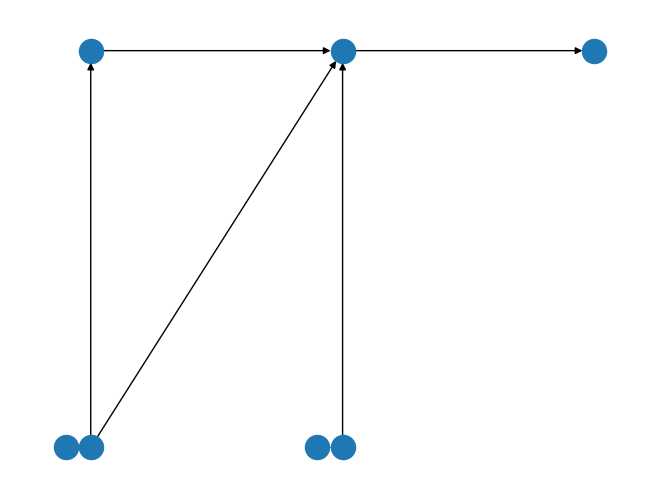

In [443]:
m = Map()
m.add_inter(1, (0,0))
m.add_inter(2, (1,0))
m.add_inter(3, (0,1))
m.add_inter(4, (1,1))
m.add_inter("sink", (2,1))
m.add_road(1, 3, dt=1, speed_limit=50, length=300, lanes=2, num_cars=0)
m.add_road(1, 4, dt=1, speed_limit=50, length=100, lanes=1, num_cars=0)
m.add_road(3, 4, dt=1, speed_limit=50, length=100, lanes=1, num_cars=0)
m.add_road(2, 4, dt=1, speed_limit=50, length=100, lanes=1, num_cars=0)
m.add_road(4, "sink", dt=1, speed_limit=50, length=100, lanes=1, num_cars=0)
m.declare_inflow_node(1, {'sink': 40})
m.declare_inflow_node(2, {'sink': 80})
m.simulation_check_compile()

In [444]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

norm = plt.Normalize(0, 1)  # Normalize to [0,25]
node_colors = [cm.YlOrRd(norm(0)) for _ in range(len(m.G.nodes))]

def update(frame):
    ax.clear()  # Clear previous frame
    
    # Update traffic by one time step
    m.update_time()
    
    # Update edge_colors
    num_cars = nx.get_edge_attributes(m.G, 'num_cars')
    # Convert weights to a list and normalize them for color mapping
    num_cars_values = list(num_cars.values())
    norm = plt.Normalize(0, 25)  # Normalize to [0,25]
    edge_colors = [cm.YlOrRd(norm(num_cars[edge])) for edge in m.G.edges]

    # Redraw graph
    nx.draw(m.G, m.node_positions, ax=ax, with_labels=True, 
            node_color=node_colors, node_size=500, 
            edge_color=edge_colors, width=4)
    
    # Create labels for terminations, num_cars
    shift_down_pos = {node: (x, y - 0.05) for node, (x, y) in m.node_positions.items()}
    
    terminations = {sink_node: "Terminations:\n" + str(round(m.G.nodes[sink_node]["terminations"],2)) for sink_node in m.sinks}
    nx.draw_networkx_labels(m.G, shift_down_pos, ax=ax, labels=terminations, font_size=8, font_color="black")
    
    road_num_cars = {edge: "Car Density: " + str(round(m.G[edge[0]][edge[1]]["num_cars"],2)) for edge in m.G.edges}
    nx.draw_networkx_edge_labels(m.G, shift_down_pos, ax=ax, edge_labels=road_num_cars, font_size=8, font_color="black")
    
fig, ax = plt.subplots()
ani = FuncAnimation(fig, update, frames=100, interval=200)
plt.close()
HTML(ani.to_jshtml())

In [440]:
list(m.G.edges)
m.G['_i2'][2]

{'dt': 1,
 'capacity': 10.0,
 'speed_limit': 50,
 'length': 100,
 'lanes': 1,
 'num_cars': 0.0}

In [436]:
m.update_time()

In [401]:
m.G.nodes[1]
m.G[1][3]
#m.G[1][4]
m.G['_i1'][1]

{'dt': 1,
 'capacity': 2500.0,
 'speed_limit': 50,
 'length': 10000,
 'lanes': 1,
 'num_cars': -4.440892098500626e-16}

In [409]:
m.G.nodes['sink']

{'terminations': 120.0}

In [314]:
m.G.nodes[4]

{(4, 'sink'): 1.0}

In [328]:
m.G[4]['sink']

{'dt': 1,
 'capacity': 25.0,
 'speed_limit': 50,
 'length': 100,
 'lanes': 1,
 'num_cars': 0.0}